**Xây dựng mô hình xác định giới tính thông qua hình ảnh với SVM**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Đọc và load dữ liệu**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Đường dẫn đến thư mục chứa dữ liệu CelebA
img_path = "/content/drive/MyDrive/Colab Notebooks/Machine Learning Arrow/list_image_celeba"
attr_path = "/content/drive/MyDrive/Colab Notebooks/Machine Learning Arrow/list_attr_celeba.csv"

# Kích thước ảnh (chuẩn hóa kích thước ảnh để thống nhất)
img_size = (64, 64)

# Đọc file thuộc tính
attributes = pd.read_csv(attr_path)

# Danh sách chứa dữ liệu và nhãn
data = []
labels = []

atrributes_need = attributes[["image_id", "Male"]]

for index, row in atrributes_need.iterrows():
    img_name = str(row.name + 1).zfill(6) + '.jpg'
    img = cv2.imread(os.path.join(img_path, img_name), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, img_size)
        data.append(img.flatten())
        labels.append(1 if row['Male'] == 1 else 0)

        # print(img)
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        # plt.show()
        # break

print(len(data))
print(len(labels))


1998
1998


In [ ]:
print(labels[0:10])

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


In [ ]:
print(data[0:10])

[array([233, 233, 233, ...,  69,  67,  69], dtype=uint8), array([ 54,  55,  59, ...,  79, 105, 124], dtype=uint8), array([255, 255, 255, ...,  91,  91,  93], dtype=uint8), array([ 58,  60, 119, ...,  53,  96,  29], dtype=uint8), array([184, 185, 186, ..., 183, 183, 181], dtype=uint8), array([255, 255, 255, ...,  31,  65,  52], dtype=uint8), array([ 87,  88,  89, ..., 151, 151, 158], dtype=uint8), array([28, 27, 28, ..., 27, 25, 26], dtype=uint8), array([ 77,  77,  80, ..., 163, 166, 156], dtype=uint8), array([ 4,  5,  6, ..., 19, 18, 18], dtype=uint8)]


**Xây dựng và huấn luyện mô hình**

In [ ]:
# Chuyển đổi danh sách thành numpy array
data = np.array(data)
labels = np.array(labels)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# Khởi tạo và huấn luyện mô hình SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = svm_model.predict(X_test)

# Đánh giá mô hình
print("Kết quả accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Female", "Male"]))

Kết quả accuracy: 0.855
              precision    recall  f1-score   support

      Female       0.88      0.88      0.88       357
        Male       0.82      0.82      0.82       243

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.86      0.85      0.86       600



**Điều chỉnh siêu tham số cho mô hình**

In [ ]:
# Tinh chỉnh siêu tham số (optional)
from sklearn.model_selection import GridSearchCV

# Định nghĩa các giá trị của siêu tham số cần thử nghiệm
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1]  # Chỉ dùng cho kernel RBF
}

# Khởi tạo mô hình GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# In ra kết quả tốt nhất
print("Giá trị tốt nhất cho các siêu tham số: ", grid_search.best_params_)
print("Giá trị cross-validation accuracy:", grid_search.best_score_)

# Huấn luyện mô hình SVM với tham số tốt nhất
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra với mô hình tốt nhất
y_pred_best = best_svm_model.predict(X_test)

# Đánh giá mô hình tốt nhất
print("Giá trị accuracy của mô hình tốt nhất:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=["Female", "Male"]))

Giá trị tốt nhất cho các siêu tham số:  {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Giá trị cross-validation accuracy: 0.8333461341525858
Giá trị accuracy của mô hình tốt nhất: 0.855
              precision    recall  f1-score   support

      Female       0.88      0.88      0.88       357
        Male       0.82      0.82      0.82       243

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.86      0.85      0.86       600



**Sử dụng mô hình cho việc dự đoán**

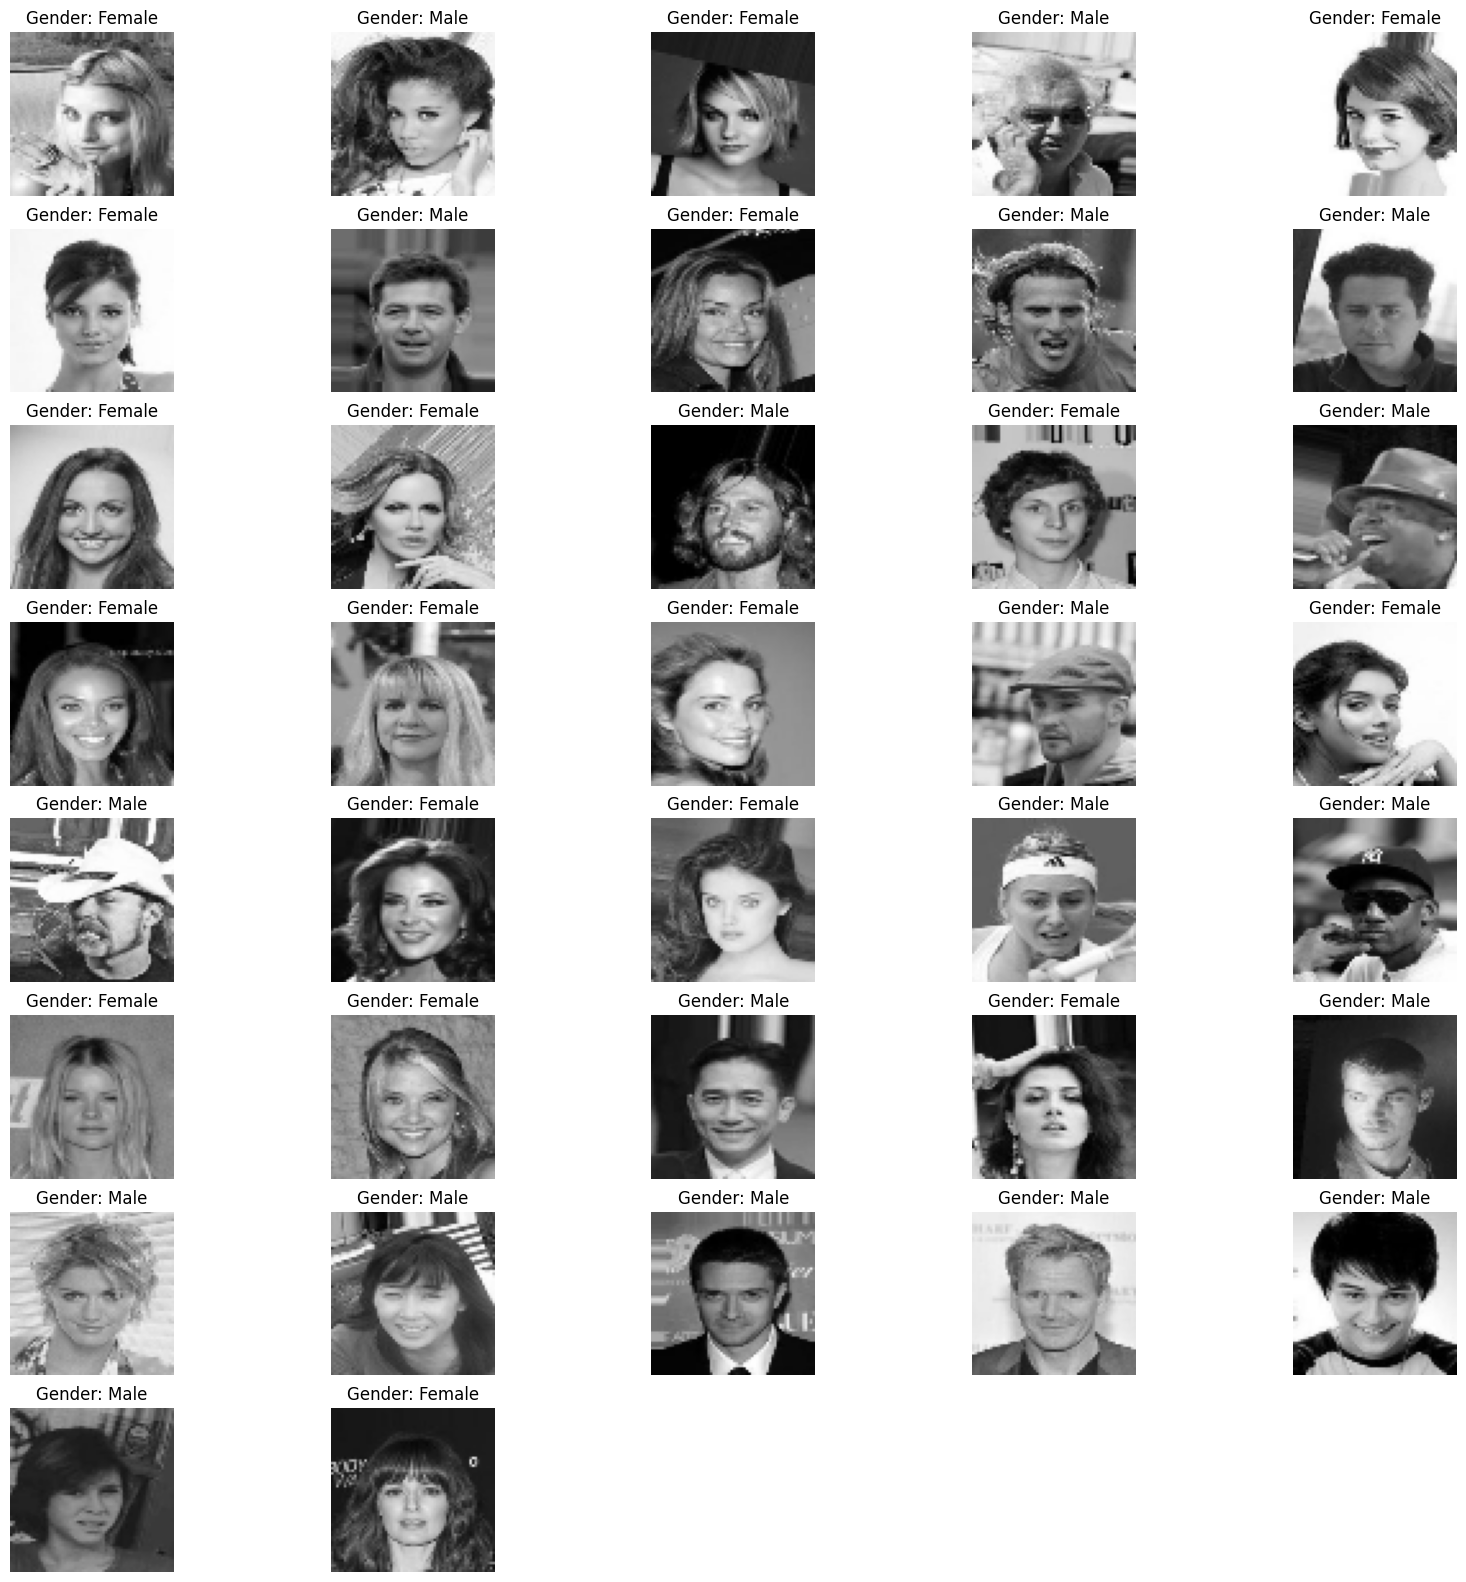

In [ ]:
def predict_gender(img_path, model):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, img_size)
        img = img.flatten().reshape(1, -1)

        prediction = model.predict(img)
        # probability = model.predict_proba(img)
        gender = "Male" if prediction[0] == 1 else "Female"
        # confidence = probability[0][prediction[0]]
        # return gender, confidence
        return gender
    else:
        raise FileNotFoundError(f"Image at path {img_path} not found")

img_path_test = "/content/drive/MyDrive/Colab Notebooks/Machine Learning Arrow/list_image_test_new"
plt.figure(figsize=(20, 20))
for i in range(41):
    img_name_test = str(i + 41653).zfill(6) + '.jpg' # vì ảnh nằm trong tên từ 41653 -> 41703
    img_path = os.path.join(img_path_test, img_name_test)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, img_size)
        plt.subplot(8, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        gender = predict_gender(img_path, best_svm_model)
        plt.title(f"Gender: {gender}")
        plt.axis('off')

# new_img_path = "/content/drive/MyDrive/Colab Notebooks/Machine Learning Arrow/list_image_test/000001.jpg"
# img_test = cv2.imread(new_img_path)
# if img_test is not None:
#     plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
#     plt.show()

# gender = predict_gender(new_img_path, best_svm_model)
# print(f"Predicted Gender: {gender}")